# Self-Driving Car Engineer Nanodegree


## Project: **Vehicle Detection and Tracking** 
***
In this project, the goal is to write a software pipeline to identify vehicles in a video from a front-facing camera on a car.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/513/view) for this project.

---

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

## Import Packages, Define Variable Defaults, & Define Some Helper Functions

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
import os
import pprint
import random
import time
from scipy.ndimage.measurements import label
from collections import defaultdict
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
%matplotlib inline

## Helper Functions for Feature Extraction

In [2]:
## Function for converting images between color spaces
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2BGR':
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    if conv == 'BGR2RGB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

In [3]:
## Function for resizing image to given pixel dimensions
def bin_spatial(img, size=(32, 32)):
    #color1 = cv2.resize(img[:,:,0], size).ravel()
    #color2 = cv2.resize(img[:,:,1], size).ravel()
    #color3 = cv2.resize(img[:,:,2], size).ravel()
    #return np.hstack((color1, color2, color3))
    
    features = cv2.resize(img, size).ravel()
    return features

In [4]:
## Function for calculating color histograms
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
## Function for calculating HOG features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Returns two elements if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, block_norm="L2-Hys",
                                  visualise=vis, feature_vector=feature_vec)
        return [features, hog_image]
    
    # Returns one element if vis==False
    else:      
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, block_norm="L2-Hys",
                       visualise=vis, feature_vector=feature_vec)
        return features

In [6]:
## Function for getting features list of an image. Can possibly combine spatial features, histogram features, and hog features
def get_color_features(img, 
                       color_space='RGB', 
                       spatial_feat=True, spatial_size=(32,32), 
                       hist_feat=True, hist_bins=32, 
                       hog_feat=True, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL', HOG_vis=False, 
                       required_output="feature_vector"):
    
    features = []
    feature_img = np.copy(img)
    
    ## Change color spaces
    if color_space != 'RGB':
        feature_img = convert_color(feature_img, conv='RGB2'+color_space)

    ## Calculate spatial features
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_img, size=spatial_size)
        features = np.concatenate((features, spatial_features))
        
    ## Calculate histogram features
    if hist_feat == True:
        hist_features = color_hist(feature_img, nbins=hist_bins)
        features = np.concatenate((features, hist_features))
        
    ## Calculate HOG featuers
    if hog_feat == True:
        if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_img.shape[2]):
                    hog_temp = get_hog_features(feature_img[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=HOG_vis, feature_vec=True)
                    hog_features.append(hog_temp[0])
                hog_features = np.ravel(hog_features) 
        else:
            hog_temp = get_hog_features(feature_img[:,:,hog_channel], 
                                      orient, pix_per_cell, cell_per_block, 
                                      vis=HOG_vis, feature_vec=True)
            hog_features = hog_temp
        # Append the new feature vector to the features list
        features = np.concatenate((features, hog_features))
            
    ## Determine output
    if required_output == "Plot":
        return feature_img
    elif required_output == "feature_vector":
        return features
    elif required_output == "SF":
        return [spatial_features , feature_img]
    elif required_output == "HF":
        return [hist_features, feature_img]
    elif required_output == "HOGF":
        return [hog_temp, feature_img]

## Import Training Data

Cars pickle data loaded!
Number of images imported:    8792
Shape of images:              (64, 64, 3)


Random Car Image  :   8263


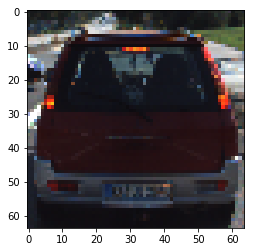

In [7]:
## Initialize variables
cars=[]

## Force a reimport of the data and overwrite the pickle
force_redo = False

## If pickle data exists, load it
if os.path.exists("training_data\\cars.p") and force_redo == False:
    cars = pickle.load(open("training_data\\cars.p","rb"))
    print("Cars pickle data loaded!")
## If pickle data does not exist, run and save it
else:
    for file in glob.glob('training_data\\vehicles\\*\\*.png'):
        img = cv2.imread(file)
        cars.append(convert_color(img, conv='BGR2RGB'))
    pickle.dump(cars , open("training_data\\cars.p","wb"))

## Print statistics
print('Number of images imported:   ' , np.asarray(cars).shape[0])
print('Shape of images:             ' , np.asarray(cars).shape[1:])

## Print test image
print("\n")
temp=random.randint(0,np.asarray(cars).shape[0])
print("Random Car Image  :  ",temp)
plt.imshow(cars[temp])
plt.show()

Non-cars pickle data loaded!
Number of images imported:    8968
Shape of images:              (64, 64, 3)


Random Non-Car Image  :   6308


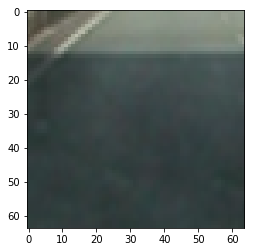

In [8]:
## Initialize variables
not_cars=[]

## Force a reimport of the data and overwrite the pickle
force_redo = False

## If pickle data exists, load it
if os.path.exists("training_data\\not_cars.p") and force_redo == False:
    not_cars = pickle.load(open("training_data\\not_cars.p","rb"))
    print("Non-cars pickle data loaded!")
## If pickle data does not exist, run and save it
else:
    for file in glob.glob('training_data\\non-vehicles\\*\\*.png'):
        img = cv2.imread(file)
        not_cars.append(convert_color(img, conv='BGR2RGB'))
    pickle.dump(not_cars , open("training_data\\not_cars.p","wb"))

## Print statistics
print('Number of images imported:   ' , np.asarray(not_cars).shape[0])
print('Shape of images:             ' , np.asarray(not_cars).shape[1:])

## Print test image
print("\n")
temp=random.randint(0,np.asarray(not_cars).shape[0])
print("Random Non-Car Image  :  ",temp)
plt.imshow(not_cars[temp])
plt.show()

## Visualize Different Color Spaces

In [9]:
## Initialize one random number so that image processing and features can be tested on same image and compared
temp=random.randint(0,np.asarray(cars).shape[0])

Random Car Image  :   5200


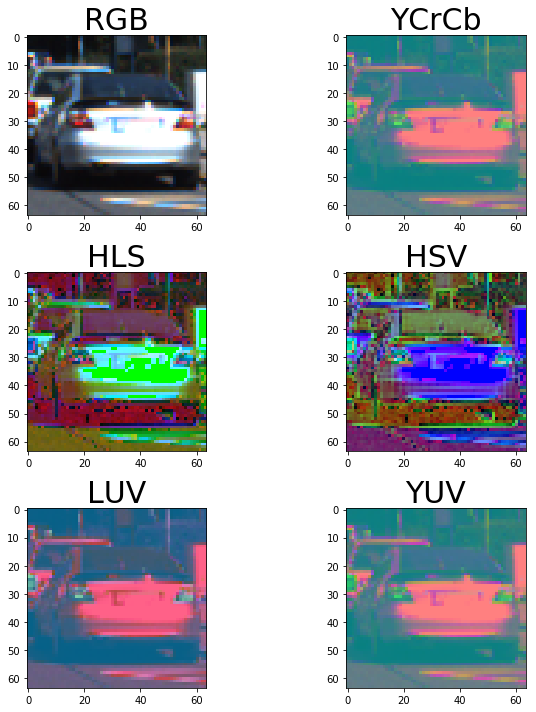

In [10]:
## Load image
img = cars[temp]

## Display different color spaces
print("Random Car Image  :  ",temp)
f, axes = plt.subplots(3, 2, figsize=(10,10))
axes[0, 0].imshow(img)
axes[0, 0].set_title('RGB', fontsize=30)
axes[0, 1].imshow(convert_color(img, conv='RGB2YCrCb'))
axes[0, 1].set_title('YCrCb', fontsize=30)
axes[1, 0].imshow(convert_color(img, conv='RGB2HLS'))
axes[1, 0].set_title('HLS', fontsize=30)
axes[1, 1].imshow(convert_color(img, conv='RGB2HSV'))
axes[1, 1].set_title('HSV', fontsize=30)
axes[2, 0].imshow(convert_color(img, conv='RGB2LUV'))
axes[2, 0].set_title('LUV', fontsize=30)
axes[2, 1].imshow(convert_color(img, conv='RGB2YUV'))
axes[2, 1].set_title('YUV', fontsize=30)
plt.tight_layout()
plt.show()

## Find Best Combination of Parameters For Classifier

In [11]:
## Enable output of each set of parameters
verbose = True

## Force a reimport of the data and overwrite the pickle
force_redo = False

## Parameters to iterate through
color_spaces = ["RGB", "YCrCb", "YUV"]  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orients = np.hstack((np.linspace(5,10,num = 3), (np.linspace(15,35,num = 3)))).astype(np.int32)
orients = [11, 20, 30]
pix_per_cells = [8, 16] # HOG pixels per cell
cell_per_blocks = [2] # HOG cells per block
hog_channels = ['ALL'] # Can be 0, 1, 2, or "ALL"
spatial_sizes = [16] # Spatial binning dimensions
hist_bins = [16] # Number of histogram bins
## [True, False], [True], [False]
spatial_feats = [True] # Spatial features on or off
hist_feats = [True] # Histogram features on or off
hog_feats = [True] # HOG features on or off

## If pickle data does not exist, run and save it
if not(os.path.exists("data\\statistics.p")) or force_redo == True:
    Statistics = defaultdict(list)
    
    ## Loop through all possible parameters
    for CS, Orient, ppc, cpb, hogCh, spatSize, bins, spatFeats, histFeats, hogFeats in [(CS, Orient, ppc, cpb, hogCh, spatSize, bins, spatFeats, histFeats, hogFeats) 
        for CS in color_spaces 
        for Orient in orients 
        for ppc in pix_per_cells 
        for cpb in cell_per_blocks 
        for hogCh in hog_channels 
        for spatSize in spatial_sizes 
        for bins in hist_bins 
        for spatFeats in spatial_feats 
        for histFeats in hist_feats 
        for hogFeats in hog_feats]:
        ## Only run if one of the feature sets is active (i.e. if all feature sets are inactive, there are no features...)
        if spatFeats or histFeats or hogFeats:
            ## Start timer
            t1 =time.time()
            
            ## Initialize variables
            cars_features = []
            not_cars_features = []
            
            ## Print parameters if verbose is TRUE
            if verbose:
                print("Color Space : " , CS)
                if spatFeats:
                    print("Spatial size  : " , spatSize)
                if histFeats:
                    print("Number of histogram bins  : " , bins)
                if hogFeats:
                    print("Number of Hog Orientations  : " , Orient)
                    print("Number of pixels per channel  : " , ppc)
                    print("Number of cells per blocks  : " , cpb)
                    print("Hog Channels  : " , hogCh)

            ## Loop through all car images and gather features. Append features to the list of all features
            for car in cars:
                car_features = get_color_features(car,
                                                  color_space=CS,
                                                  spatial_feat=spatFeats, spatial_size=(spatSize,spatSize),
                                                  hist_feat=histFeats, hist_bins=bins, 
                                                  hog_feat=hogFeats, orient=Orient, pix_per_cell=ppc, cell_per_block=cpb, 
                                                  hog_channel=hogCh, HOG_vis=False,
                                                  required_output = "feature_vector")
                cars_features.append(car_features)

            ## Loop through all non-car images and gather features. Append features to the list of all features
            for not_car in not_cars:
                not_car_features = get_color_features(not_car,
                                                  color_space=CS,
                                                  spatial_feat=spatFeats, spatial_size=(spatSize,spatSize),
                                                  hist_feat=histFeats, hist_bins=bins, 
                                                  hog_feat=hogFeats, orient=Orient, pix_per_cell=ppc, cell_per_block=cpb, 
                                                  hog_channel=hogCh, HOG_vis=False,
                                                  required_output = "feature_vector")
                not_cars_features.append(not_car_features)

            ## Stack features and labels
            X = np.vstack((cars_features,not_cars_features,not_cars_features,not_cars_features)).astype(np.float64)
            y = np.hstack((np.ones(len(cars_features)),np.zeros(len(not_cars_features)),np.zeros(len(not_cars_features)),np.zeros(len(not_cars_features))))

            ## Calculate scaler
            X_scaler = StandardScaler().fit(X)
            X_scaled = X_scaler.transform(X)

            ## Split into train and test data
            rand_state = 45
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.05, random_state = rand_state)

            ## Train classifier
            svc = LinearSVC()
            svc.fit(X_train,y_train)
            
            ## Calculate statistics of classifier
            t2=time.time()
            time_train = round(t2-t1,2)
            accuracy = svc.score(X_test,y_test)

            ## Print statistics if verbose is TRUE
            if verbose:
                print(time_train, "seconds to generate features and train classifier")
                print("{0:0.4f}% test accuracy".format(accuracy*100))
                print("\n\n")

            ## Add data to dict
            Statistics["CS"].append(CS)
            Statistics["Orient"].append(Orient)
            Statistics["ppc"].append(ppc)
            Statistics["cpb"].append(cpb)
            Statistics["hogCh"].append(hogCh)
            Statistics["spatSize"].append(spatSize)
            Statistics["bins"].append(bins)
            Statistics["spatFeats"].append(spatFeats)
            Statistics["histFeats"].append(histFeats)
            Statistics["hogFeats"].append(hogFeats)
            Statistics["time_train"].append(time_train)
            Statistics["Accuracy"].append(accuracy)

    ## Save pickle data
    pickle.dump(Statistics, open("data\\statistics.p","wb"))

## If pickle data exists, load it
else:
    Statistics = pickle.load(open("data\\statistics.p","rb"))
    print("Statistics pickle data loaded!")

Statistics pickle data loaded!


## Recalculate and Save Best Classifer

In [12]:
bestClf = {}

## Force a reimport of the data and overwrite the pickle
force_redo = False

## If pickle data does not exist, run and save it
if not(os.path.exists("data\\best_clf.p")) or force_redo == True:
    ## Determine highest accuracy and index (disregard duplicate values, they will operate equally well)
    bestAccuracy = max(Statistics["Accuracy"])
    bestIndex = Statistics["Accuracy"].index(bestAccuracy)

    ## Store best data into new dict
    bestClf["CS"] = Statistics["CS"][bestIndex]
    bestClf["Orient"] = Statistics["Orient"][bestIndex]
    bestClf["ppc"] = Statistics["ppc"][bestIndex]
    bestClf["cpb"] = Statistics["cpb"][bestIndex]
    bestClf["hogCh"] = Statistics["hogCh"][bestIndex]
    bestClf["spatSize"] = Statistics["spatSize"][bestIndex]
    bestClf["bins"] = Statistics["bins"][bestIndex]
    bestClf["spatFeats"] = Statistics["spatFeats"][bestIndex]
    bestClf["histFeats"] = Statistics["histFeats"][bestIndex]
    bestClf["hogFeats"] = Statistics["hogFeats"][bestIndex]
    
    ## Store best data into runtime vars
    CS = bestClf["CS"]
    Orient = bestClf["Orient"]
    ppc = bestClf["ppc"]
    cpb = bestClf["cpb"]
    hogCh = bestClf["hogCh"]
    spatSize = bestClf["spatSize"]
    bins = bestClf["bins"]
    spatFeats = bestClf["spatFeats"]
    histFeats = bestClf["histFeats"]
    hogFeats = bestClf["hogFeats"]
    
    ## Initialize vars
    cars_features = []
    not_cars_features = []

    ## Loop through all car images and gather features. Append features to the list of all features
    for car in cars:
        car_features = get_color_features(car,
                                          color_space=CS,
                                          spatial_feat=spatFeats, spatial_size=(spatSize,spatSize),
                                          hist_feat=histFeats, hist_bins=bins, 
                                          hog_feat=hogFeats, orient=Orient, pix_per_cell=ppc, cell_per_block=cpb, 
                                          hog_channel=hogCh, HOG_vis=False,
                                          required_output = "feature_vector")
        cars_features.append(car_features)

    ## Loop through all non-car images and gather features. Append features to the list of all features
    for not_car in not_cars:
        not_car_features = get_color_features(not_car,
                                          color_space=CS,
                                          spatial_feat=spatFeats, spatial_size=(spatSize,spatSize),
                                          hist_feat=histFeats, hist_bins=bins, 
                                          hog_feat=hogFeats, orient=Orient, pix_per_cell=ppc, cell_per_block=cpb, 
                                          hog_channel=hogCh, HOG_vis=False,
                                          required_output = "feature_vector")
        not_cars_features.append(not_car_features)

    ## Stack features and labels
    X = np.vstack((cars_features,not_cars_features,not_cars_features,not_cars_features)).astype(np.float64)
    y = np.hstack((np.ones(len(cars_features)),np.zeros(len(not_cars_features)),np.zeros(len(not_cars_features)),np.zeros(len(not_cars_features))))

    ## Calculate scaler
    X_scaler = StandardScaler().fit(X)
    X_scaled = X_scaler.transform(X)

    ## Split into train and test data
    rand_state = 45
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = rand_state)

    ## Train classifier
    svc = LinearSVC()
    t1 =time.time()
    svc.fit(X_train,y_train)
    t2=time.time()

    ## Calculate statistics of classifier
    time_train = round(t2-t1,2)
    accuracy = svc.score(X_test,y_test)
    bestClf["time_train"] = time_train
    bestClf["Accuracy"] = accuracy
    
    ## Add classifier to dict
    bestClf["scaler"] = X_scaler
    bestClf["svc"] = svc
    
    ## Save pickle data
    pickle.dump(bestClf, open("data\\best_clf.p","wb"))

## If pickle data exists, load it
else:
    bestClf = pickle.load(open("data\\best_clf.p","rb"))
    print("Classifier pickle data loaded!\n")
    X_scaler = bestClf["scaler"]
    svc = bestClf["svc"]

## Print out properties of best classifier
print("Color Space : " , bestClf["CS"])
if bestClf["spatFeats"]:
    print("Spatial size  : " , bestClf["spatSize"])
if bestClf["histFeats"]:
    print("Number of histogram bins  : " , bestClf["bins"])
if bestClf["hogFeats"]:
    print("Number of Hog Orientations  : " , bestClf["Orient"])
    print("Number of pixels per channel  : " , bestClf["ppc"])
    print("Number of cells per blocks  : " , bestClf["cpb"])
    print("Hog Channels  : " , bestClf["hogCh"])
print("\n")
print(bestClf["time_train"], "seconds to train")
print("{0:0.4f}% test accuracy".format(bestClf["Accuracy"]*100))

Classifier pickle data loaded!

Color Space :  YUV
Spatial size  :  16
Number of histogram bins  :  16
Number of Hog Orientations  :  11
Number of pixels per channel  :  16
Number of cells per blocks  :  2
Hog Channels  :  ALL


14.55 seconds to train
98.3613% test accuracy


## Helper Functions for Vehicle Detection

In [13]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [14]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [15]:
def apply_threshold(image, low_threshold=None, high_threshold=None):
    if low_threshold == None:
        low_threshold = np.min(image)-1
    if high_threshold == None:
        high_threshold = np.max(image)+1
    # Zero out pixels outside the thresholds
    image[image <= low_threshold] = 0
    image[image >= high_threshold] = 0
    # Return thresholded image
    return image

In [16]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [17]:
def draw_labeled_bboxes(img, labels):
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        bboxes.append(bbox)

    boxed_img = draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)
    # Return the image
    return boxed_img

In [18]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

In [19]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_windows=[(64, 64)], xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    window_list = []
    
    for xy_window in xy_windows:
        # Compute the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        # Initialize a list to append window positions to
        
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]

                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [20]:
def region_of_interest (img, vertices):
    mask = np.zeros_like(img)

    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask,vertices,ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [21]:
def slope_line(pts):
    pt1 = pts[0]
    pt2 = pts[1]
    return ((pt2[1]-pt1[1])/(pt2[0]-pt1[0]))

In [22]:
def search_windows(img, windows, clf, scaler, color_space='YCrCb', 
                    spatial_size=(32, 32), hist_bins=32, 
                    orient=27,
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=False, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    conf_list = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = get_color_features(test_img,
                                      color_space=color_space,
                                      spatial_feat=spatial_feat, spatial_size=spatial_size,
                                      hist_feat=hist_feat, hist_bins=hist_bins, 
                                      hog_feat=hog_feat, orient=orient, pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, 
                                      hog_channel=hog_channel, HOG_vis=False,
                                      required_output = "feature_vector")
        #print(np.asarray(features).shape)
        #5) Scale extracted features to be fed to classifier
        #print(features)
        #print(np.asarray(features).shape)
        #print(np.array(features).reshape(1, -1))
        features = np.array(features).reshape(1, -1)
        test_features = scaler.transform(features)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        conf = clf.decision_function(test_features)
        
        #print(prediction)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            #print(window, conf)
            if conf > 0.93:
                on_windows.append(window)
                
    #8) Return windows for positive detections
    return on_windows

## Test on Still Images

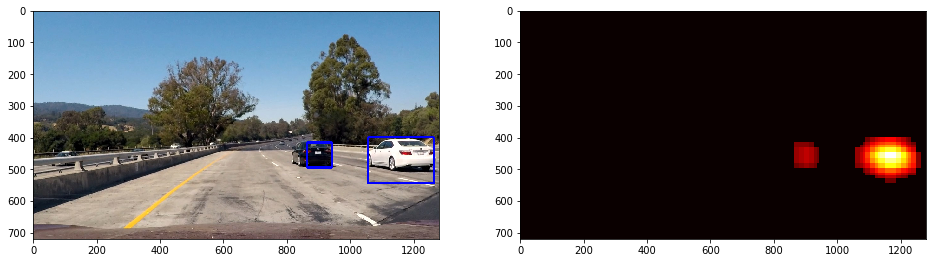

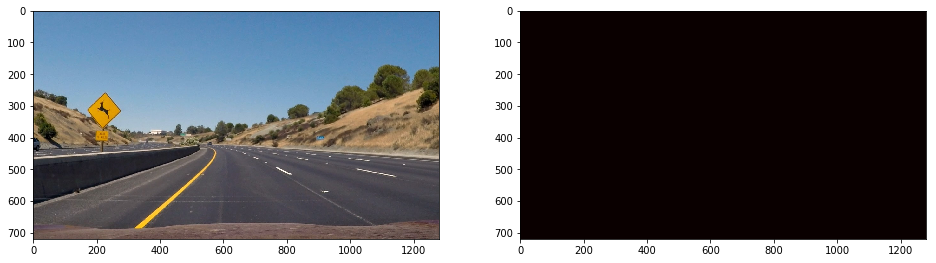

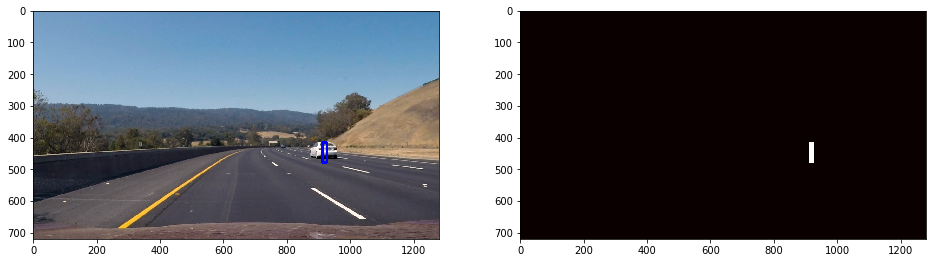

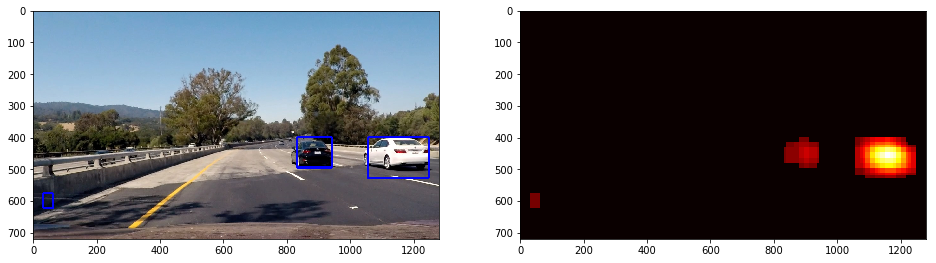

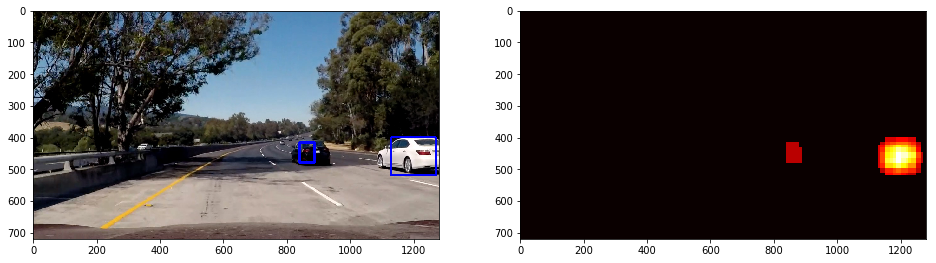

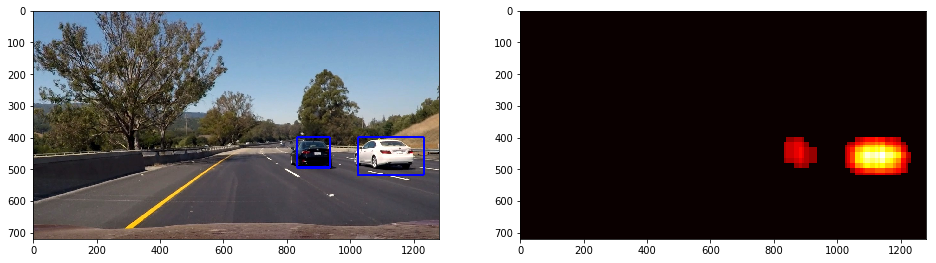

In [23]:
test_images=glob.glob("test_images\\test*.jpg")

## Store best data into runtime vars
CS = bestClf["CS"]
Orient = bestClf["Orient"]
ppc = bestClf["ppc"]
cpb = bestClf["cpb"]
hogCh = bestClf["hogCh"]
spatSize = bestClf["spatSize"]
bins = bestClf["bins"]
spatFeats = bestClf["spatFeats"]
histFeats = bestClf["histFeats"]
hogFeats = bestClf["hogFeats"]
X_scaler = bestClf["scaler"]
svc = bestClf["svc"]

for image in test_images:
#img = mpimg.imread("test_images/test5.jpg")
    FileName = image.split('\\')[-1]
    img = mpimg.imread(image)    
    draw_image=np.copy(img)
    
    windows = slide_window(draw_image,x_start_stop=[None,None], y_start_stop=[400,720],
                          xy_windows = [(64, 64), (96, 96), (128, 128)], xy_overlap = (0.75,0.75))
    window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)
    
    hot_windows = search_windows(draw_image, 
                                 windows, 
                                 svc, X_scaler, 
                                 color_space=CS, 
                                 spatial_size=(spatSize, spatSize), hist_bins=bins, 
                                 orient=Orient, pix_per_cell=ppc, 
                                 cell_per_block=cpb, 
                                 hog_channel=hogCh, spatial_feat=spatFeats, 
                                 hist_feat=histFeats, hog_feat=hogFeats)  
    
    # Add heat to each box in box list
    heat=np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    heat = apply_threshold(heat, 4)
    #print(np.amax(heat))
    heatmap = np.clip(heat, 0 ,255)
    
    labels = label(heatmap)
    #print(labels)

    draw_img2 = draw_labeled_bboxes(draw_image, labels)
    
    # Save final image
    outputFile = "output_images/output_"+FileName
    mpimg.imsave(outputFile, draw_img2)

    fig=plt.figure(figsize=(16,9))
    plt.subplot(121)
    plt.imshow(draw_img2)
    plt.subplot(122)
    plt.imshow(heatmap, cmap ='hot')
    plt.show()

### HeatMap Helper Class

This class is used to track and average information about heatmaps over multiple frames of a video sequence.

In [24]:
# Define a class to receive the characteristics of each line detection
class HeatMapClass():
    def __init__(self):
        
        ### Instance Definitions/constants
            
        # number of frames to average
        self.n_average = 30
        

        ### Latest values
        
        # Current Frame number
        self.current_Frame = 1
        
        # List of heatmaps
        self.list_heatmaps = []
        
    def add_heatmap(self, heatmap):
        #print(heatmap)
        if len(self.list_heatmaps) == self.n_average:
            self.list_heatmaps.remove(self.list_heatmaps[0])
        self.list_heatmaps.append(heatmap)
        
    def sum_heatmaps(self):
        total_heatmap = self.list_heatmaps[0]
        for i in range(1, len(self.list_heatmaps)):
            total_heatmap += self.list_heatmaps[i]
        return total_heatmap
        
        

## Pipeline Definition

In [25]:
## Define pipeline to run on each image
def pipeline(img):
    global HeatMapInst
    
    if HeatMapInst is None:
        HeatMapInst = HeatMapClass()
    
    draw_image=np.copy(img)
    
    windows = slide_window(draw_image, x_start_stop=[None,None], y_start_stop=[400,720],
                          xy_windows = [(64, 64), (96, 96), (128, 128)], xy_overlap = (0.75,0.75))
    window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)
    
    hot_windows = search_windows(draw_image, 
                                 windows, 
                                 svc, X_scaler, 
                                 color_space=CS, 
                                 spatial_size=(spatSize, spatSize), hist_bins=bins, 
                                 orient=Orient, pix_per_cell=ppc, 
                                 cell_per_block=cpb, 
                                 hog_channel=hogCh, spatial_feat=spatFeats, 
                                 hist_feat=histFeats, hog_feat=hogFeats)  
    
    # Add heat to each box in box list
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, hot_windows)
    heatmap = np.clip(heatmap, 0 ,255)
    
    # Add to helper class for tracking heat map history
    HeatMapInst.add_heatmap(heatmap)
    total_heatmap = HeatMapInst.sum_heatmaps()
    
    # Apply threshold
    total_heatmap = apply_threshold(total_heatmap, 120)
    
    # Calculate Labels
    labels = label(total_heatmap)

    # Draw boxes
    draw_img2 = draw_labeled_bboxes(draw_image, labels)
    
    #fig=plt.figure(figsize=(16,9))
    #plt.subplot(131)
    #plt.imshow(draw_img2)
    #plt.subplot(132)
    #plt.imshow(heatmap, cmap ='hot')
    #plt.subplot(133)
    #plt.imshow(total_heatmap, cmap ='hot')
    #plt.show()
    
    return draw_img2

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
videos = glob.glob('test_videos\\*.mp4')
pprint.pprint(videos)

['test_videos\\project_video.mp4', 'test_videos\\test_video.mp4']


In [ ]:
global HeatMapInst

#for inputFile in glob.glob('*.mp4'):
for inputFile in ['test_videos\\test_video.mp4']:
    FileName = inputFile.split('\\')[-1]
    
    HeatMapInst = HeatMapClass()

    # Read in video
    clip = VideoFileClip(inputFile)#.subclip(38,42)
        
    # Process video
    output_clip = clip.fl_image(pipeline) #NOTE: this function expects color images!!
    
    # Save final image
    outputFile = "output_videos/output_"+FileName
    %time output_clip.write_videofile(outputFile, audio=False)
    
    del clip, output_clip

[MoviePy] >>>> Building video output_videos/output_test_video.mp4
[MoviePy] Writing video output_videos/output_test_video.mp4


 15%|███████▏                                       | 6/39 [00:41<03:48,  6.91s/it]

In [ ]:
video_file = 'output_videos\\output_test_video.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_file))

In [ ]:
global HeatMapInst

#for inputFile in glob.glob('*.mp4'):
for inputFile in ['test_videos\\project_video.mp4']:
    FileName = inputFile.split('\\')[-1]
    
    HeatMapInst = HeatMapClass()

    # Read in video
    clip = VideoFileClip(inputFile)#.subclip(38,42)
        
    # Process video
    output_clip = clip.fl_image(pipeline) #NOTE: this function expects color images!!
    
    # Save final image
    outputFile = "output_videos/output_"+FileName
    %time output_clip.write_videofile(outputFile, audio=False)
    
    del clip, output_clip

In [ ]:
video_file = 'output_videos\\output_project_video.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_file))